# INIT

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification
!unzip /content/gtzan-dataset-music-genre-classification.zip # gtzan rozpakuj

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes
 99% 1.20G/1.21G [00:09<00:00, 172MB/s]
100% 1.21G/1.21G [00:09<00:00, 132MB/s]
Archive:  /content/gtzan-dataset-music-genre-classification.zip
  inflating: Data/features_30_sec.csv  
  inflating: Data/features_3_sec.csv  
  inflating: Data/genres_original/blues/blues.00000.wav  
  inflating: Data/genres_original/blues/blues.00001.wav  
  inflating: Data/genres_original/blues/blues.00002.wav  
  inflating: Data/genres_original/blues/blues.00003.wav  
  inflating: Data/genres_original/blues/blues.00004.wav  
  inflating: Data/genres_original/blues/blues.00005.wav  
  inflating: Data/genres_original/blues/blues.00006.wav  
  inflating: Data/genres_original/blues/blues.00007.wav  
  inflating: Data/genres_original/blues/blues.00008.wav  
  inflating: Data/genres_original/blues/blues.00009.wav  
  inflating: Data/genres_original/blues/blues.00010.wav  
  inflating: Data/genres_original/blues/blues.00011

In [ ]:
!cp /content/drive/MyDrive/Music_Dataset/dataset.zip . 
!cp /content/drive/MyDrive/Music_Dataset/CNN_CLASIFIER_annotations_withgtzan_v2.csv .
!unzip dataset.zip

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: dataset/Ed Sheeran -  Divide Full Album (Deluxe)_sec_17400.0_17700.0.mp3  
  inflating: dataset/Ed Sheeran -  Divide Full Album (Deluxe)_sec_17800.0_18100.0.mp3  
  inflating: dataset/Ed Sheeran -  Divide Full Album (Deluxe)_sec_19200.0_19500.0.mp3  
  inflating: dataset/Ed Sheeran -  Divide Full Album (Deluxe)_sec_19600.0_19900.0.mp3  
  inflating: dataset/Ed Sheeran -  Divide Full Album (Deluxe)_sec_21000.0_21300.0.mp3  
  inflating: dataset/Ed Sheeran -  Divide Full Album (Deluxe)_sec_21400.0_21700.0.mp3  
  inflating: dataset/Ed Sheeran -  Divide Full Album (Deluxe)_sec_22800.0_23100.0.mp3  
  inflating: dataset/Ed Sheeran -  Divide Full Album (Deluxe)_sec_23200.0_23500.0.mp3  
  inflating: dataset/Ed Sheeran -  Divide Full Album (Deluxe)_sec_24600.0_24900.0.mp3  
  inflating: dataset/Ed Sheeran -  Divide Full Album (Deluxe)_sec_25000.0_25300.0.mp3  
  inflating: dataset/Ed Sheeran -  Divide Full Album (D

In [ ]:
import os
# USUN DISCO I COUNTRY PRZERZUC DO FOLDERU
for dir in os.listdir("/content/Data/genres_original"):
  for file in os.listdir("/content/Data/genres_original/"+dir):
    if "disco" in file:
      os.remove("/content/Data/genres_original/"+dir+"/"+file)
    elif "country" in file:
      os.remove("/content/Data/genres_original/"+dir+"/"+file)
    else:
      if file.endswith(".wav"):
        os.rename("/content/Data/genres_original/"+dir+"/"+file, "/content/dataset/"+file)


In [ ]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio

class AudioUtil():
  # ----------------------------
  # Load an audio file. Return the signal as a tensor and the sample rate
  # ----------------------------
  @staticmethod
  def open(audio_file):
    sig, sr = torchaudio.load(audio_file)
    return (sig, sr)

  # ----------------------------
  # Convert the given audio to the desired number of channels
  # ----------------------------
  @staticmethod
  def rechannel(aud, new_channel):
    sig, sr = aud

    if (sig.shape[0] == new_channel):
      # Nothing to do
      return aud

    if (new_channel == 1):
      # Convert from stereo to mono by selecting only the first channel
      resig = sig[:1, :]
    elif (new_channel == 3):
      resig = sig[:1, :]
      resig = torch.cat(3*[resig])
      '''
      print(sig.shape)
      print(sig.size())
      channel = sig[0,:]
      
      resig = sig.expand(3, -1)

      x[0,:] = channel
      x[1,:] = channel
      x[2,:] = channel
      '''
    else:
      # Convert from mono to stereo by duplicating the first channel
      resig = torch.cat([sig, sig])

    return ((resig, sr))

  # ----------------------------
  # Since Resample applies to a single channel, we resample one channel at a time
  # ----------------------------
  @staticmethod
  def resample(aud, newsr):
    sig, sr = aud

    if (sr == newsr):
      # Nothing to do
      return aud

    num_channels = sig.shape[0]
    # Resample first channel
    resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
    if (num_channels > 1):
      # Resample the second channel and merge both channels
      retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
      resig = torch.cat([resig, retwo])

    return ((resig, newsr))

  # ----------------------------
  # Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds
  # ----------------------------
  @staticmethod
  def pad_trunc(aud, max_ms): # TU WCHODZI ILE MA TRWAC
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms 

    if (sig_len > max_len):
      # Truncate the signal to the given length
      sig = sig[:,:max_len]

    elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      sig = torch.cat((pad_begin, sig, pad_end), 1)
      
    return (sig, sr)

  # ---------------------------- DATA AUGUMENTATION
  # Shifts the signal to the left or right by some percent. Values at the end
  # are 'wrapped around' to the start of the transformed signal.
  # ----------------------------
  @staticmethod
  def time_shift(aud, shift_limit):
    sig,sr = aud
    _, sig_len = sig.shape
    shift_amt = int(random.random() * shift_limit * sig_len)
    return (sig.roll(shift_amt), sr)
  
  # ----------------------------
  # Generate a Spectrogram
  # ----------------------------
  @staticmethod
  def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig,sr = aud
    top_db = 80

    # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
    spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

    # Convert to decibels
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
    return (spec)
  

  # ---------------------------- MEL AUGUMENTATION
  # Augment the Spectrogram by masking out some sections of it in both the frequency
  # dimension (ie. horizontal bars) and the time dimension (vertical bars) to prevent
  # overfitting and to help the model generalise better. The masked sections are
  # replaced with the mean value.
  # ----------------------------
  @staticmethod
  def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    _, n_mels, n_steps = spec.shape
    mask_value = spec.mean()
    aug_spec = spec

    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_masks):
      aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_masks):
      aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

    return aug_spec

from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio

# ----------------------------
# Sound Dataset
# ----------------------------
class SoundDS(Dataset):
  def __init__(self, df, data_path, duration=30000, shift_pct=0.4):
    self.df = df #
    self.data_path = str(data_path) # /content/dataset/
    self.duration = duration # tu bylo 4000 ms czyli 4s
    self.sr = 44100
    self.channel = 3 # ZMIANA NA 3 kanaly zeby sie zgadzalo
    self.shift_pct = shift_pct
            
  # ----------------------------
  # Number of items in dataset
  # ----------------------------
  def __len__(self):
    return len(self.df)    
    
  # ----------------------------
  # Get i'th item in dataset
  # ----------------------------
  def __getitem__(self, idx):
    # Absolute file path of the audio file - concatenate the audio directory with
    # the relative path
    audio_file = self.data_path + self.df.loc[idx, 'filename'] # tu bylo relative_path zamiast filename
    # Get the Class ID
    class_id = self.df.loc[idx, 'label'] # tu bylo classID zamiast label
    class_id = int(class_id)
    aud = AudioUtil.open(audio_file) # jakby dodac to.device!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    # Some sounds have a higher sample rate, or fewer channels compared to the
    # majority. So make all sounds have the same number of channels and same 
    # sample rate. Unless the sample rate is the same, the pad_trunc will still
    # result in arrays of different lengths, even though the sound duration is
    # the same.
    reaud = AudioUtil.resample(aud, self.sr)
    rechan = AudioUtil.rechannel(reaud, self.channel)

    dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
    shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
    sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None) # tu mozna sie pobawic parametrami
    aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

    return aug_sgram, class_id

In [ ]:
''' save preprocessed and augumented Dataset
1. Remove duplicates
2. Iterate
- wav/mp3 to pt
- save
3. zip
4. copy to disc
'''

# save tensor to png
nie dziala
**Save spectrograms to png for faster training**



```
DATASET ZWRACA 

return aug_sgram, class_id, self.df.loc[idx, 'filename']
```



In [ ]:
import pandas as pd
import numpy as np


BATCH_SIZE = 1

df = pd.read_csv("/content/CNN_CLASIFIER_annotations_withgtzan_v2.csv")
data_path = "/content/dataset/"

myds = SoundDS(df, data_path)
mel_png = torch.utils.data.DataLoader(myds, batch_size=BATCH_SIZE, shuffle=False)

print(myds.size())

In [ ]:
from torchvision.utils import save_image
import cv2 as cv

def mels_to_png(mel_png):
    for image, label, audio_filename in mel_png:
        # dostaje 1 zjdecie i 1 label sprawdzic shape
        image = torch.squeeze(image)
        #print(image.shape)
        #print(torch.min(image))
        #print(label.shape)
        #print(label)
        #print(audio_filename) # nazwa pliku
        save_image(image, 'image.png')
        break
    return image
original_tensor = mels_to_png(mel_png)
print(torch.min(original_tensor))

def read_pnt_to_mel(png_path):
    image = cv.imread(png_path)
    image = torch.from_numpy(image)
    return image

loaded_tensor = read_pnt_to_mel("/content/image.png")

loaded_tensor = loaded_tensor.permute(2, 0, 1)
print(torch.min(loaded_tensor))

tensor(-35.1965)
tensor(0, dtype=torch.uint8)


# inaa

In [ ]:
audio_classes = ['blues', 'classical', 'electronic', 'electronic(vibe)', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
label_dict = {
    "blues" : 0,
    "classical" : 1,
    "electronic" : 2,
    "electronic(vibe)" : 3,
    "hiphop" : 4,
    "jazz" : 5,
    "metal" : 6,
    "pop" : 7,
    "reggae" : 8,
    "rock" : 9
}

In [ ]:
import pandas as pd
from torch.utils.data import random_split
import numpy as np

############## POEKSPERYMENTOWAC Z BATCH_SIZE
BATCH_SIZE = 16

df = pd.read_csv("/content/CNN_CLASIFIER_annotations_withgtzan_v2.csv")
data_path = "/content/dataset/"

myds = SoundDS(df, data_path, duration=4000, shift_pct=0.4)

# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, test_ds = random_split(myds, [num_train, num_val])

# Create training and validation data loaders
# batch_size jak dobierac spradzic
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

myds[0][0].shape

torch.Size([3, 64, 344])

# Baseline: Classification with softmax

1. RESNETS

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class EmbeddingNet(nn.Module):
    def __init__(self, latent_dim=128, architecture=18):
        super(EmbeddingNet, self).__init__()
        self.architecture = architecture
        self.feature_extractor = self._getResnet(latent_dim=latent_dim)

    def forward(self, x):
        x = self.feature_extractor(x)
        return x

    def _getResnet(self,latent_dim):
        '''
        Sprawdzic czy daje tez FC
        '''
        if self.architecture == 18:
            model = models.resnet18(pretrained=True)
        elif self.architecture == 34:
            model = models.resnet34(pretrained=True)
        elif self.architecture == 50:
            model = models.resnet50(pretrained=True)
        elif self.architecture == 101:
            model = models.resnet101(pretrained=True)
        elif self.architecture == 152:
            model = models.resnet152(pretrained=True)
        else: print("MODEL NOT LOADED")
        
        for param in model.parameters():
            param.requires_grad= False # freeze beggining layer
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, latent_dim)
    


        return model

    def get_embedding(self, x):
        return self.forward(x)

class ClassificationNet(nn.Module):
    def __init__(self, embedding_net, n_classes, latent_dim):
        super(ClassificationNet, self).__init__()
        self.embedding_net = embedding_net
        self.n_classes = n_classes
        self.latent_dim = latent_dim
        self.nonlinear = nn.PReLU()
        self.fc1 = nn.Linear(latent_dim, n_classes) # 

    def forward(self, x):
        output = self.embedding_net(x)
        output = self.nonlinear(output)
        scores = F.log_softmax(self.fc1(output), dim=-1)
        return scores

    def get_embedding(self, x):
        return self.nonlinear(self.embedding_net(x))

embed_model = EmbeddingNet(latent_dim=512, architecture=152)
x = torch.randn(1, 3, 64, 344)
output = embed_model(x)
print(output.shape)

classifi = ClassificationNet(embed_model, 10, latent_dim=512)
x = torch.randn(1, 3, 64, 344)
output_class = classifi(x)
print(output_class.shape)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

torch.Size([1, 512])
torch.Size([1, 10])


In [ ]:


# Feature Extractor
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class EfficentEmbeddingNet(nn.Module):
    def __init__(self, latent_dim=128, architecture=0):
        super(EfficentEmbeddingNet, self).__init__()
        self.architecture = architecture
        self.feature_extractor = self._getEfficientNet(latent_dim=latent_dim)

    def forward(self, x):
        x = self.feature_extractor(x)
        return x

    def _getEfficientNet(self,latent_dim):
        '''
        Sprawdzic czy daje tez FC
        '''
        if self.architecture == 0:
            model = models.efficientnet_b0(pretrained=True)
        elif self.architecture == 1:
            model = models.efficientnet_b1(pretrained=True)
        elif self.architecture == 2:
            model = models.efficientnet_b2(pretrained=True)
        elif self.architecture == 3:
            model = models.efficientnet_b3(pretrained=True)
        elif self.architecture == 4:
            model = models.efficientnet_b4(pretrained=True)
        elif self.architecture == 5:
            model = models.efficientnet_b5(pretrained=True)
        elif self.architecture == 6:
            model = models.efficientnet_b6(pretrained=True)
        elif self.architecture == 7:
            model = models.efficientnet_b7(pretrained=True)
        else: print("MODEL NOT LOADED")
        
        # to czy napewno tak
        for param in model.parameters():
            param.requires_grad= False # freeze beggining layer
        model.classifier[1] = nn.Linear(in_features=1280, out_features=latent_dim)
        #print(model.classifier

        return model

    def get_embedding(self, x):
        return self.forward(x)

class EfficentClassificationNet(nn.Module):
    def __init__(self, embedding_net, n_classes, latent_dim):
        super(EfficentClassificationNet, self).__init__()
        self.embedding_net = embedding_net
        self.n_classes = n_classes
        self.latent_dim = latent_dim
        self.nonlinear = nn.PReLU()
        '''
        Both Flatten and GlobalAveragePooling2D are valid options. So is GlobalMaxPooling2D.

        Flatten will result in a larger Dense layer afterwards, which is 
        more expensive and may result in worse overfitting. But if you have lots of data, it might also perform better.

        As usual, it depends completely on your problem.
        '''
        self.fc1 = nn.Linear(latent_dim, n_classes) # 

    def forward(self, x):
        output = self.embedding_net(x)
        output = self.nonlinear(output)
        scores = F.log_softmax(self.fc1(output), dim=-1)
        return scores

    def get_embedding(self, x):
        return self.nonlinear(self.embedding_net(x))

embed_model = EfficentEmbeddingNet(latent_dim=512, architecture=0)
x = torch.randn(1, 3, 64, 344)
output = embed_model(x)
print(output.shape)

classifi = EfficentClassificationNet(embed_model, 10, latent_dim=512)
x = torch.randn(1, 3, 64, 344)
output_class = classifi(x)
print(output_class.shape)

torch.Size([1, 512])
torch.Size([1, 10])


In [ ]:


# Feature Extractor
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class EfficentEmbeddingNet_other(nn.Module):
    def __init__(self, latent_dim=128, architecture=0):
        super(EfficentEmbeddingNet, self).__init__()
        self.architecture = architecture
        self.feature_extractor = self._getEfficientNet(latent_dim=latent_dim)

    def forward(self, x):
        x = self.feature_extractor(x)
        return x

    def _getEfficientNet(self,latent_dim):
        '''
        Sprawdzic czy daje tez FC
        '''
        if self.architecture == 0:
            model = models.efficientnet_b0(pretrained=True)
        elif self.architecture == 1:
            model = models.efficientnet_b1(pretrained=True)
        elif self.architecture == 2:
            model = models.efficientnet_b2(pretrained=True)
        elif self.architecture == 3:
            model = models.efficientnet_b3(pretrained=True)
        elif self.architecture == 4:
            model = models.efficientnet_b4(pretrained=True)
        elif self.architecture == 5:
            model = models.efficientnet_b5(pretrained=True)
        elif self.architecture == 6:
            model = models.efficientnet_b6(pretrained=True)
        elif self.architecture == 7:
            model = models.efficientnet_b7(pretrained=True)
        else: print("MODEL NOT LOADED")
        
        # to czy napewno tak
        for param in model.parameters():
            param.requires_grad= False # freeze beggining layer 
        
        # przed 1280 na 10   >> global_average_pooling2d >> batch_normalization >>  (Dropout)  >> dense_6 (Dense) 1280 na 10
        model.classifier[1] = nn.Linear(in_features=1280, out_features=10)
        #print(model.classifier

        return model

    def get_embedding(self, x):
        return self.forward(x)

class EfficentClassificationNet(nn.Module):
    def __init__(self, embedding_net, n_classes, latent_dim):
        super(EfficentClassificationNet, self).__init__()
        self.embedding_net = embedding_net
        self.n_classes = n_classes
        self.latent_dim = latent_dim
        self.nonlinear = nn.PReLU()
        '''
        Both Flatten and GlobalAveragePooling2D are valid options. So is GlobalMaxPooling2D.

        Flatten will result in a larger Dense layer afterwards, which is 
        more expensive and may result in worse overfitting. But if you have lots of data, it might also perform better.

        As usual, it depends completely on your problem.
        '''
        self.fc1 = nn.Linear(latent_dim, n_classes) # 

    def forward(self, x):
        output = self.embedding_net(x)
        output = self.nonlinear(output)
        scores = F.log_softmax(self.fc1(output), dim=-1)
        return scores

    def get_embedding(self, x):
        return self.nonlinear(self.embedding_net(x))

embed_model = EfficentEmbeddingNet(latent_dim=512, architecture=0)
x = torch.randn(1, 3, 64, 344)
output = embed_model(x)
print(output.shape)

classifi = EfficentClassificationNet(embed_model, 10, latent_dim=512)
x = torch.randn(1, 3, 64, 344)
output_class = classifi(x)
print(output_class.shape)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models


model = models.efficientnet_b0(pretrained=True)

for param in model.parameters():
    param.requires_grad= False


model
#model.classifier[1] = nn.Linear(in_features=1280, out_features=10)

In [ ]:
model.classifier[1] = nn.Linear(in_featyures, 10)

AdaptiveAvgPool2d(output_size=1)

# TRAIN TEST FUNCTIONS

In [ ]:
# idal train loop
'''
2. early stopping
3. easy connect to weights and biases
4. latwa w modulowaniu
5. loss/accuracy i inne jesli potrzebne
6. tqdm albo w&b
7. print co iles mini batch np 10% epoki
'''
def train_epoch(train_loader, optimizer, device, model, loss_fn, log_interval):
    running_loss = 0.
    train_loss = 0.
    for i, data in enumerate(train_loader):
        images, labels = data
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        preds = model(images)
        loss = loss_fn(preds, labels)
        loss.backward() # Calculates the backward gradients over the learning weights

        optimizer.step() # Tells the optimizer to perform one learning step - that is, adjust the model’s learning weights
                         # based on the observed gradients for this batch, according to the optimization algorithm we chose It
                         #  reports on the loss for every log_interval. (log_interval = 500) -> every 500 batches
        running_loss += loss.item()
        if i % log_interval == 0:
            train_loss = running_loss / loss # loss per batch
            print('  batch {} loss: {}'.format(i + 1, train_loss))
            running_loss = 0.
    return train_loss # loss calej epoki

def test_epoch(test_loader, model, device, loss_fn, save_best=False):
    '''
    OUTPUT
    jesli chce sie dokladnosc w procentach to pomnozyc correct * 100 !
    '''
    best_accuracy = 0
    test_loss = 0
    correct = 0
    size = len(test_loader.dataset) # ? czy to naprwno tak sprawdzic
    num_batches = len(test_loader)  # ?
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            preds = model(images)
            test_loss += loss_fn(preds, labels).item()
            correct += (preds.argmax(1) == labels).type(torch.float).sum().item()
    test_loss = test_loss / num_batches
    correct = correct / size
    if save_best is True:
        if correct > best_accuracy:
            torch.save(model, 'best-model.pt')
            torch.save(model.state_dict(), 'best-model-parameters.pt')
            best_accuracy = correct
    print("Accuracy {}, Test_loss {}".format(correct*100, test_loss))
    return correct, test_loss

def train_model(epoch, model, train_loader, test_loader, optimizer, device, loss_fn, scheduler, log_interval, save_best=False, start_epoch=0):
    for i in range(0, start_epoch): # po co ? bo dziala od ktorejs epoki czasami !!!
        scheduler.step()

    train_loss_tab = []
    test_loss_tab = []
    accuracy_tab = []
    for i in range(start_epoch, epoch):
        train_loss = train_epoch(train_loader, optimizer, device, model, loss_fn, log_interval)
        accuracy, test_loss = test_epoch(test_loader, model, device, loss_fn, save_best=save_best)
        scheduler.step()
        train_loss_tab.append(train_loss)
        test_loss_tab.append(test_loss)
        accuracy_tab.append(accuracy)
    return train_loss_tab, test_loss_tab, accuracy_tab


In [ ]:
import torch.optim.lr_scheduler
import torch.optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

latent_dim = 128

embedding_model = EmbeddingNet(latent_dim=latent_dim, architecture=34).to(device)
model_classification = ClassificationNet(embedding_model, 10, latent_dim=latent_dim).to(device)

loss_fn = torch.nn.NLLLoss()
lr = 1e-2
optimizer = torch.optim.Adam(model_classification.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 8
log_interval = 50 # ?


cuda:0


In [ ]:
train_tab, test_tab, acc_tab = train_model(epoch=n_epochs,
                                           model=model_classification,
                                           train_loader=train_dl,
                                           test_loader=test_dl,
                                           optimizer=optimizer,
                                           device=device,
                                           loss_fn=loss_fn,
                                           scheduler=scheduler,
                                           log_interval=100, # to lepiej ogarnac
                                           save_best=True,
                                           start_epoch=0)
# 25min 1 epoka na resnet  50  - 30 sek dane
# 24:47 start 15min  epoka jakos
# preprocess danych nie jest nma gpu chyba dlatego tak dlugo to trwa

  batch 1 loss: 1.0
  batch 101 loss: 100.00543975830078
  batch 201 loss: 102.75122833251953
  batch 301 loss: 105.60599517822266
Accuracy 36.0919540229885, Test_loss 1.7908680148240996
  batch 1 loss: 1.0
  batch 101 loss: 92.45731353759766
  batch 201 loss: 96.13599395751953
  batch 301 loss: 121.52803039550781
Accuracy 33.639846743295024, Test_loss 1.8284321732637359
  batch 1 loss: 1.0
  batch 101 loss: 96.44847869873047
  batch 201 loss: 111.07157135009766
  batch 301 loss: 85.91714477539062
Accuracy 37.01149425287356, Test_loss 1.8034587139036597
  batch 1 loss: 1.0
  batch 101 loss: 108.36941528320312
  batch 201 loss: 123.77244567871094
  batch 301 loss: 81.65238189697266
Accuracy 38.31417624521073, Test_loss 1.6580796619740927
  batch 1 loss: 1.0
  batch 101 loss: 93.16629028320312
  batch 201 loss: 111.26626586914062
  batch 301 loss: 114.9343032836914
Accuracy 40.689655172413794, Test_loss 1.671766534084227


In [ ]:
# rozpisac ktore zle/dobrze klasyfikuje z kazdego gatunku i dlaczwego 
# ten wykres jebany se zrobic
# Dataset usprawnic

In [ ]:
def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

In [ ]:
#Reduce with PCA or Tsne 128 dim to only 2
# pca wszytsjkie naraz
# w ktorych mozna dorzucac jak w embedding; na apke

In [ ]:
def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)

In [ ]:
# Plot embeddings in Weights and biases

In [ ]:
pip install torchinfo

In [ ]:
from torchinfo import summary
summary(model_classification, input_size=(1, 3, 64, 2579))

Layer (type:depth-idx)                             Output Shape              Param #
ClassificationNet                                  --                        --
├─EmbeddingNet: 1-1                                [1, 512]                  --
│    └─ResNet: 2-1                                 [1, 512]                  --
│    │    └─Conv2d: 3-1                            [1, 64, 32, 1290]         (9,408)
│    │    └─BatchNorm2d: 3-2                       [1, 64, 32, 1290]         (128)
│    │    └─ReLU: 3-3                              [1, 64, 32, 1290]         --
│    │    └─MaxPool2d: 3-4                         [1, 64, 16, 645]          --
│    │    └─Sequential: 3-5                        [1, 256, 16, 645]         (215,808)
│    │    └─Sequential: 3-6                        [1, 512, 8, 323]          (2,339,840)
│    │    └─Sequential: 3-7                        [1, 1024, 4, 162]         (40,613,888)
│    │    └─Sequential: 3-8                        [1, 2048, 2, 81]          (14,

# TODO

1. preprocess szybszy (zmiana na zdjecia gotowe juz)
2. W&B
3. model z gtzan < -- (do tego w&b ny sie przydalo)

# W&B Experiments

In [ ]:
import pandas as pd
from torch.utils.data import random_split
import numpy as np

In [ ]:
%%capture
!pip install wandb --upgrade

In [ ]:
import wandb

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
sweep_config = {
    'method' : 'random',
}
metric = {
    'name' : 'test_loss',
    'goal' : 'minimize'
}
sweep_config['metric'] = metric
# name the hperparameters
parameters_dict = {
    'epochs': {
        'values': [3, 5]
    },
    'batch_size': {
        'values': [16, 32, 64]
    },
    'duration': {
        'values': [4000, 8000, 15000, 25000] # /1000 zeby bylo w sekundach
    },
    'shift_pct': {
        'values': [0.4, 0.2]
    },
    'latent_dim': {
        'values': [256, 512]
    },
    'optimizer': {
        'values': ['adam', 'sgd', 'RMSprop'] # z scheduler
    },
    'scheduler': {
        'values': ['ExponentialLR', 'CyclicLR - exp_range'] # z scheduler
    },
    'models': {
        'values': ['Resnet34', 'EfficentNet0'] # z scheduler
    }
}
sweep_config['parameters'] = parameters_dict

In [ ]:
from pprint import pprint
pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'test_loss'},
 'parameters': {'batch_size': {'values': [16, 32, 64]},
                'duration': {'values': [4000, 8000, 15000, 25000]},
                'epochs': {'values': [3, 5]},
                'latent_dim': {'values': [256, 512]},
                'models': {'values': ['Resnet34', 'EfficentNet0']},
                'optimizer': {'values': ['adam', 'sgd', 'RMSprop']},
                'scheduler': {'values': ['ExponentialLR',
                                         'CyclicLR - exp_range']},
                'shift_pct': {'values': [0.4, 0.2]}}}


In [ ]:
sweep_id = wandb.sweep(sweep_config, project="MUSIC_CLASSIFICATION")

Create sweep with ID: xpt0sfaz
Sweep URL: https://wandb.ai/wualas/MUSIC_CLASSIFICATION/sweeps/xpt0sfaz


In [ ]:
def build_network(model_name, latent_dim):
    # do zmiany ale izi
    if model_name == 'Resnet18':
        architecture = 18
        embed_model = EmbeddingNet(latent_dim=latent_dim, architecture=architecture).to(device)
        model = ClassificationNet(embed_model, 10, latent_dim=latent_dim).to(device)
    if model_name == 'Resnet34':
        architecture = 34
        embed_model = EmbeddingNet(latent_dim=latent_dim, architecture=architecture).to(device)
        model = ClassificationNet(embed_model, 10, latent_dim=latent_dim).to(device)
    if model_name == 'EfficentNet0':
        architecture = 0
        embed_model = EfficentEmbeddingNet(latent_dim=latent_dim, architecture=architecture).to(device)
        model = EfficentClassificationNet(embed_model, 10, latent_dim=latent_dim).to(device)
    if model_name == 'MyFuckingNetwork':
        model = MyFuckingNetwork().to(device)
    return model

def build_optimizer(network, optimizer):
    if optimizer == "sgd":
        optimizer = torch.optim.SGD(network.parameters(),
                              lr=0.01, momentum=0.9)
    elif optimizer == "adam":
        optimizer = torch.optim.Adam(network.parameters(),
                               lr=3e-4)
    elif optimizer == 'RMSprop':
        optimizer = torch.optim.RMSprop(network.parameters(),
                                lr=0.01)
    return optimizer

def build_scheduler(optimizer, scheduler):
    '''
    w schedulerach jest tyle hiperparametrow ze japierodle
    '''
    if scheduler == 'ExponentialLR':
      scheduler = torch.optim.lr_scheduler.ExponentialLR(
          optimizer, gamma=0.1
      )
    elif scheduler == 'CyclicLR - exp_range':
      scheduler = torch.optim.lr_scheduler.CyclicLR(
          optimizer, base_lr=0.001, max_lr=0.1,step_size_up=5,
          mode="exp_range",gamma=0.85, cycle_momentum=False
      )
    return scheduler

def build_loader(df, data_path, batch_size, duration=30000, shift_pct=0.4, experimental=None):
    '''
    experimental = 0.6 menas that 60% of dataset will be deleted for wandb research
    '''
    myds = SoundDS(df, data_path, duration=duration, shift_pct=shift_pct)

    # Random split of 80:20 between training and validation
    num_items = len(myds)


    if experimental != None:
        to_remove = round(num_items * experimental)
        num_items = len(myds) - to_remove
        num_train = round(num_items * 0.8)
        num_val = num_items - num_train
        remove_ds, train_ds, test_ds = random_split(myds, [to_remove,num_train, num_val])
        print("WORKS")
    else:
        num_train = round(num_items * 0.8)
        num_val = num_items - num_train
        train_ds, test_ds = random_split(myds, [num_train, num_val])
    # Create training and validation data loaders
    # batch_size jak dobierac spradzic
    train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    return train_dl, test_dl

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = nn.CrossEntropyLoss()
df = pd.read_csv("/content/CNN_CLASIFIER_annotations_withgtzan_v2.csv")
data_path = "/content/dataset/"

def train_model_wandb(config=None):
    with wandb.init(config=config):
        config = wandb.config
        train_dl, test_dl = build_loader(df, data_path, config.batch_size, config.duration, config.shift_pct, experimental=0.6)
        model = build_network(config.models, config.latent_dim)
        optimizer = build_optimizer(model, config.optimizer)
        scheduler = build_scheduler(optimizer, config.scheduler)
        for epoch in range(config.epochs):
            print(f"Epoch {epoch+1}\n-------------------------------")
            train_loss = train_epoch(train_dl, optimizer, device, model, loss_fn, 100)
            accuracy, test_loss = test_epoch(test_dl, model, device, loss_fn, save_best=False)
            scheduler.step()
            wandb.log({'epoch': epoch, 'test_loss': test_loss, 'train_loss': train_loss, 'accuracy': accuracy})

In [ ]:
wandb.agent(sweep_id, function=train_model_wandb, count=5)

wandb: Agent Starting Run: xm369377 with config:
wandb: 	batch_size: 8
wandb: 	duration: 8000
wandb: 	epochs: 4
wandb: 	latent_dim: 512
wandb: 	models: EfficentNet0
wandb: 	optimizer: sgd
wandb: 	scheduler: ExponentialLR
wandb: 	shift_pct: 0.2


WORKS
Epoch 1
-------------------------------
  batch 1 loss: 1.0
  batch 101 loss: 113.75459289550781
  batch 201 loss: 104.04815673828125
Accuracy 39.272030651341, Test_loss 1.6987473495078809
Epoch 2
-------------------------------
  batch 1 loss: 1.0
  batch 101 loss: 118.47662353515625
  batch 201 loss: 76.14639282226562
Accuracy 47.509578544061306, Test_loss 1.544988650264162
Epoch 3
-------------------------------
  batch 1 loss: 1.0
  batch 101 loss: 121.53935241699219
  batch 201 loss: 130.8271484375
Accuracy 46.36015325670498, Test_loss 1.5702572853276224
Epoch 4
-------------------------------
  batch 1 loss: 0.9999999403953552
  batch 101 loss: 96.98963165283203
  batch 201 loss: 127.63470458984375
Accuracy 44.827586206896555, Test_loss 1.5866799769979534



accuracy,▁█▇▆
epoch,▁▃▆█
test_loss,█▁▂▃
train_loss,▅▁██
accuracy,0.44828
epoch,3
test_loss,1.58668
train_loss,127.6347


wandb: Agent Starting Run: cpn47oy6 with config:
wandb: 	batch_size: 16
wandb: 	duration: 4000
wandb: 	epochs: 6
wandb: 	latent_dim: 512
wandb: 	models: Resnet34
wandb: 	optimizer: RMSprop
wandb: 	scheduler: CyclicLR - exp_range
wandb: 	shift_pct: 0.4


WORKS
Epoch 1
-------------------------------
  batch 1 loss: 1.0
  batch 101 loss: 141.89784240722656
Accuracy 32.18390804597701, Test_loss 1.8987957239151
Epoch 2
-------------------------------
  batch 1 loss: 1.0
  batch 101 loss: 3644.871337890625
Accuracy 19.157088122605366, Test_loss 2.2052187197136157
Epoch 3
-------------------------------
  batch 1 loss: 1.0
  batch 101 loss: 3664.314697265625
Accuracy 21.455938697318008, Test_loss 2.222345297986811
Epoch 4
-------------------------------
  batch 1 loss: 1.0
  batch 101 loss: 12126.6025390625
Accuracy 28.35249042145594, Test_loss 2.1966320420756484
Epoch 5
-------------------------------
  batch 1 loss: 1.0
  batch 101 loss: 2.0980050563812256
Accuracy 20.689655172413794, Test_loss 22.389896884109035
Epoch 6
-------------------------------
  batch 1 loss: 1.0
  batch 101 loss: 163.32737731933594
Accuracy 6.321839080459771, Test_loss 23.241143255522758



accuracy,█▄▅▇▅▁
epoch,▁▂▄▅▇█
test_loss,▁▁▁▁██
train_loss,▁▃▃█▁▁
accuracy,0.06322
epoch,5
test_loss,23.24114
train_loss,163.32738


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qwgvj81i with config:
wandb: 	batch_size: 32
wandb: 	duration: 4000
wandb: 	epochs: 2
wandb: 	latent_dim: 256
wandb: 	models: Resnet18
wandb: 	optimizer: adam
wandb: 	scheduler: CyclicLR - exp_range
wandb: 	shift_pct: 0.6


WORKS
Epoch 1
-------------------------------
  batch 1 loss: 1.0
Accuracy 36.59003831417624, Test_loss 1.8100581519743975
Epoch 2
-------------------------------
  batch 1 loss: 1.0
Accuracy 31.03448275862069, Test_loss 2.0656288511612835



accuracy,█▁
epoch,▁█
test_loss,▁█
train_loss,▁▁
accuracy,0.31034
epoch,1
test_loss,2.06563
train_loss,1.0


wandb: Agent Starting Run: vcxjrsc4 with config:
wandb: 	batch_size: 64
wandb: 	duration: 25000
wandb: 	epochs: 2
wandb: 	latent_dim: 512
wandb: 	models: Resnet18
wandb: 	optimizer: sgd
wandb: 	scheduler: CyclicLR - exp_range
wandb: 	shift_pct: 0.2


WORKS
Epoch 1
-------------------------------
  batch 1 loss: 1.0
Accuracy 24.71264367816092, Test_loss 2.1506599850124783
Epoch 2
-------------------------------
  batch 1 loss: 1.0


# Conclusions after first analysis

* Needs check!
* For next W&B analysis use spectrum not solid values for e.g. duration
* Check different Loss Functions for Classification

```
Optimizer --> SGD
Scheduler --> Exp LR
Shift PCT --> 0.2 - 0.4 [I use 0.4]
Model ------> Resnet 18 - 34 [I use 18]
Latent Dim -> 512 - 256 [I use 256]
Epochs -----> 6 minimum
Batch Size -> 16
Duration ---> 15 - 25 k [I use 25k] 
```



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class EmbeddingNet(nn.Module):
    def __init__(self, latent_dim=128, architecture=18):
        super(EmbeddingNet, self).__init__()
        self.architecture = architecture
        self.feature_extractor = self._getResnet(latent_dim=latent_dim)
        self.fc = nn.Sequential(
                                nn.PReLU(), # bo pierwsza liniowa jest juz wpisana w getresnet
                                nn.Linear(256, 256)
                                # PRelu po tej liniowej jest wpisane w classification
                                )
    def forward(self, x):
        x = self.feature_extractor(x)
        return x

    def _getResnet(self,latent_dim):
        '''
        Sprawdzic czy daje tez FC
        '''
        if self.architecture == 18:
            model = models.resnet18(pretrained=True)
        elif self.architecture == 34:
            model = models.resnet34(pretrained=True)
        elif self.architecture == 50:
            model = models.resnet50(pretrained=True)
        elif self.architecture == 101:
            model = models.resnet101(pretrained=True)
        elif self.architecture == 152:
            model = models.resnet152(pretrained=True)
        else: print("MODEL NOT LOADED")
        
        for param in model.parameters():
            param.requires_grad= False # freeze beggining layer
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, latent_dim)
    


        return model

    def get_embedding(self, x):
        return self.forward(x)

class ClassificationNet(nn.Module):
    def __init__(self, embedding_net, n_classes, latent_dim):
        super(ClassificationNet, self).__init__()
        self.embedding_net = embedding_net
        self.n_classes = n_classes
        self.latent_dim = latent_dim
        self.nonlinear = nn.PReLU()
        self.fc1 = nn.Linear(latent_dim, n_classes) # 

    def forward(self, x):
        output = self.embedding_net(x)
        output = self.nonlinear(output)
        scores = F.log_softmax(self.fc1(output), dim=-1)
        return scores

    def get_embedding(self, x):
        return self.nonlinear(self.embedding_net(x))

embed_model = EmbeddingNet(latent_dim=512, architecture=152)
x = torch.randn(1, 3, 64, 344)
output = embed_model(x)
print(output.shape)

classifi = ClassificationNet(embed_model, 10, latent_dim=512)
x = torch.randn(1, 3, 64, 344)
output_class = classifi(x)
print(output_class.shape)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

torch.Size([1, 512])
torch.Size([1, 10])


In [ ]:
import pandas as pd
import numpy as np
from torch.utils.data import random_split
import torch.optim.lr_scheduler
import torch.optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
df = pd.read_csv("/content/CNN_CLASIFIER_annotations_withgtzan_v2.csv")
data_path = "/content/dataset/"

batch_size = 16
shift_pct = 0.4
duration = 25000
myds = SoundDS(df, data_path, duration=duration, shift_pct=shift_pct)
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, test_ds = random_split(myds, [num_train, num_val])
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False)

latent_dim = 256
architecture = 18
embed_model = EmbeddingNet(latent_dim=latent_dim, architecture=architecture).to(device)
model_classification = ClassificationNet(embed_model, 10, latent_dim=latent_dim).to(device)

optimizer = torch.optim.SGD(model_classification.parameters(),
                        lr=0.01, momentum=0.9)

scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer, gamma=0.1)

loss_fn = nn.CrossEntropyLoss()
n_epochs = 6

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
train_tab, test_tab, acc_tab = train_model(epoch=n_epochs,
                                           model=model_classification,
                                           train_loader=train_dl,
                                           test_loader=test_dl,
                                           optimizer=optimizer,
                                           device=device,
                                           loss_fn=loss_fn,
                                           scheduler=scheduler,
                                           log_interval=100, # to lepiej ogarnac
                                           save_best=True,
                                           start_epoch=0)

  batch 1 loss: 1.0
  batch 101 loss: 107.73197174072266
  batch 201 loss: 79.1739501953125
  batch 301 loss: 121.70319366455078
Accuracy 52.79693486590038, Test_loss 1.3257463021976192
  batch 1 loss: 1.0
  batch 101 loss: 110.17449188232422
  batch 201 loss: 113.90743255615234
  batch 301 loss: 65.92716979980469
Accuracy 55.47892720306513, Test_loss 1.2692064453915852
  batch 1 loss: 1.0
  batch 101 loss: 110.14523315429688
  batch 201 loss: 142.10153198242188
  batch 301 loss: 111.5665512084961
Accuracy 57.31800766283525, Test_loss 1.2437811777359102
  batch 1 loss: 0.9999999403953552
  batch 101 loss: 91.80436706542969
  batch 201 loss: 85.56575012207031
  batch 301 loss: 197.26524353027344
Accuracy 56.62835249042145, Test_loss 1.2282257065540407
  batch 1 loss: 1.0
  batch 101 loss: 62.40946960449219
  batch 201 loss: 85.07564544677734
  batch 301 loss: 79.19488525390625
Accuracy 57.08812260536399, Test_loss 1.2578008814555843
  batch 1 loss: 0.9999999403953552
  batch 101 loss: 1

In [ ]:
# dir one
!cp /content/best-model.pt /content/drive/MyDrive/projects/Music_system_Recommender/one
!cp /content/best-model-parameters.pt /content/drive/MyDrive/projects/Music_system_Recommender/one

In [ ]:
!cp /content/drive/MyDrive/projects/Music_system_Recommender/one/best-model-parameters.pt .

In [ ]:
!cp /content/drive/MyDrive/projects/Music_system_Recommender/one/best-model-parameters.pt .
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
latent_dim = 256
architecture = 18
embed_model = EmbeddingNet(latent_dim=latent_dim, architecture=architecture).to(device)
model_classification = ClassificationNet(embed_model, 10, latent_dim=latent_dim).to(device)
model_classification.load_state_dict(torch.load('/content/best-model-parameters.pt', map_location=device))

<All keys matched successfully>

In [14]:
def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 256)) # 256 - latent dim
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            images = images.to(device)
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

#embeddings, labels = extract_embeddings(test_dl, model_classification)

**PCA**

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(embeddings)

In [13]:
genre_classes = ['blues', 'classical', 'electronic', 'electronic(vibe)', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.8, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(genre_classes)
plot_embeddings(principalComponents, labels)

NameError: ignored

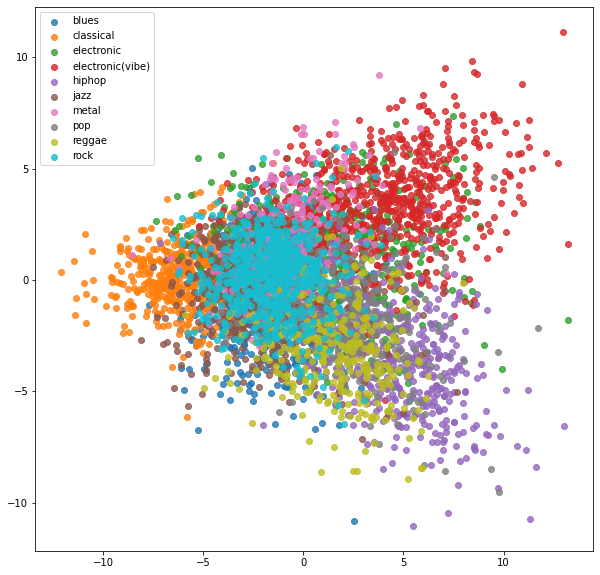

In [ ]:
from sklearn.decomposition import PCA
embeddings_train, labels_train = extract_embeddings(train_dl, model_classification)
pca = PCA(n_components=2)
principalComponents_train = pca.fit_transform(embeddings_train)
plot_embeddings(principalComponents_train, labels_train)

In [ ]:
# wykresy kwadratowe ktore z kazdej klasy ile dobrych dopasowan ma !

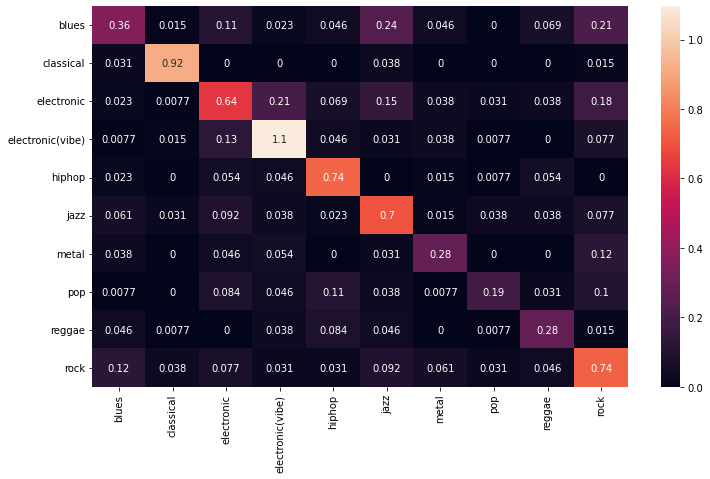

In [ ]:

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model_classification(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = genre_classes

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [ ]:
# ile ktorych mam w dataset sprawdzic
# do ktorych klas przypisano nuty z popu np
# samemu ogarne

# TODO

1. EDA - baza danych oraz wyniki
* z ktorego gatunku mam ile przykladow
* Ktore wykrylo dobrze/zle i do ktorego przypisalo cos jak confussion matrix
2. Music recommender engine
* czyli wszytskich dobrac osadzenia i porownac z wrzuconym kawalkiem - ZROBIONE
3. Unsupervised Methods
* k mean (polacazyc ze znajdywaniem ile ma byc clusterow a nie gatunkowo)
* czy da sie wywnioskowac cos z latent space z nich
4. PREPROCESSED DATA SAVE TO GDRIVE - ZROBIONE

In [ ]:
!cp /content/drive/MyDrive/projects/Music_system_Recommender/one/best-model-parameters.pt .
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
latent_dim = 256
architecture = 18
embed_model = EmbeddingNet(latent_dim=latent_dim, architecture=architecture).to(device)
model_classification = ClassificationNet(embed_model, 10, latent_dim=latent_dim).to(device)
model_classification.load_state_dict(torch.load('/content/best-model-parameters.pt', map_location=device))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
import pandas as pd

class AudioUtilEngine():
  # ----------------------------
  # Load an audio file. Return the signal as a tensor and the sample rate
  # ----------------------------
  @staticmethod
  def open(audio_file):
    sig, sr = torchaudio.load(audio_file)
    return (sig, sr)

  # ----------------------------
  # Convert the given audio to the desired number of channels
  # ----------------------------
  @staticmethod
  def rechannel(aud, new_channel):
    sig, sr = aud

    if (sig.shape[0] == new_channel):
      # Nothing to do
      return aud

    if (new_channel == 1):
      # Convert from stereo to mono by selecting only the first channel
      resig = sig[:1, :]
    elif (new_channel == 3):
      resig = sig[:1, :]
      resig = torch.cat(3*[resig])
      '''
      print(sig.shape)
      print(sig.size())
      channel = sig[0,:]
      
      resig = sig.expand(3, -1)

      x[0,:] = channel
      x[1,:] = channel
      x[2,:] = channel
      '''
    else:
      # Convert from mono to stereo by duplicating the first channel
      resig = torch.cat([sig, sig])

    return ((resig, sr))

  # ----------------------------
  # Since Resample applies to a single channel, we resample one channel at a time
  # ----------------------------
  @staticmethod
  def resample(aud, newsr):
    sig, sr = aud

    if (sr == newsr):
      # Nothing to do
      return aud

    num_channels = sig.shape[0]
    # Resample first channel
    resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
    if (num_channels > 1):
      # Resample the second channel and merge both channels
      retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
      resig = torch.cat([resig, retwo])

    return ((resig, newsr))

  # ----------------------------
  # Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds
  # ----------------------------
  @staticmethod
  def pad_trunc(aud, max_ms): # TU WCHODZI ILE MA TRWAC
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms 

    if (sig_len > max_len):
      # Truncate the signal to the given length
      sig = sig[:,:max_len]

    elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      sig = torch.cat((pad_begin, sig, pad_end), 1)
      
    return (sig, sr)

  # ----------------------------
  # Generate a Spectrogram
  # ----------------------------
  @staticmethod
  def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig,sr = aud
    top_db = 80

    # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
    spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

    # Convert to decibels
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
    return (spec)


from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio

class SoundDSEngine(Dataset):
  def __init__(self, df, data_path, duration=30000, shift_pct=0.4):
    self.df = df #
    self.data_path = str(data_path) # /content/dataset/
    self.duration = duration # tu bylo 4000 ms czyli 4s
    self.sr = 44100
    self.channel = 3 # ZMIANA NA 3 kanaly zeby sie zgadzalo
    self.shift_pct = shift_pct

  def __len__(self):
    return len(self.df)    
    
  def __getitem__(self, idx):
    audio_file = self.data_path + self.df.loc[idx, 'filename'] # tu bylo relative_path zamiast filename
    #print(audio_file)
    aud = AudioUtilEngine.open(audio_file)
    reaud = AudioUtilEngine.resample(aud, self.sr)
    rechan = AudioUtilEngine.rechannel(reaud, self.channel)
    dur_aud = AudioUtilEngine.pad_trunc(rechan, self.duration)
    sgram = AudioUtilEngine.spectro_gram(dur_aud, n_mels=64, n_fft=1024, hop_len=None) # tu mozna sie pobawic parametrami
    return sgram, audio_file


BATCH_SIZE = 1
duration = 25000
df = pd.read_csv("/content/CNN_CLASIFIER_annotations_withgtzan_v2.csv")
data_path = "/content/dataset/"
myds = SoundDSEngine(df, data_path, duration=duration, shift_pct=0.4)
engine_dl = torch.utils.data.DataLoader(myds, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

In [ ]:
'''
Przepisac dataloader:
1.  ma zwracac:
- osadzenie
- nazwe nuty
'''
import numpy as np
sr = 44100
channel = 3
batch_size = 1 
shift_pct = 0.4
duration = 25000
latent_dim = 256
def extract_embeddings(model, dataloader, save=False):
    '''
    TQDM DODAC
    '''
    data_len = len(dataloader)
    embeddings = np.zeros((data_len,latent_dim)) # datalen , embedding(latent dim) #
    names = [] 
    with torch.no_grad():
        model.eval()
        k = 0
        for song ,name in dataloader:
            song = song.to(device)
            embeddings[k:k+len(song)] = model.get_embedding(song).data.cpu().numpy() # .data z numpy ogarnac
            names.append(name)
            k += len(song)
    if save is True:
        print("ZAPISUJE WYNIKI DO PLIKU")
        with open('embeddings_classification.npy', 'wb') as f:
            np.save(f, embeddings)
    return embeddings, names

def _get_names_in_order(dataloader):
    names = [] 
    for _ ,name in dataloader:
        names.append(name)
    return names
def extract_one_embedding(audio_file, model):
    '''
    IN:
    audio_file - path to audiofile
    OUT:
    256 dimensional embedding of audiofile
    '''
    aud = AudioUtilEngine.open(audio_file)
    reaud = AudioUtilEngine.resample(aud, sr)
    rechan = AudioUtilEngine.rechannel(reaud, channel)
    dur_aud = AudioUtilEngine.pad_trunc(rechan, duration)
    sgram = AudioUtilEngine.spectro_gram(dur_aud, n_mels=64, n_fft=1024, hop_len=None) # tu mozna sie pobawic parametrami
    with torch.no_grad():
        model.eval()
        sgram = torch.Tensor(sgram).to(device)
        sgram = torch.unsqueeze(sgram, 0)
        output = model.get_embedding(sgram)
    return output, audio_file

def recommender_engine(embeddings, song_paths, song, song_name):
    ''' 
    DATABASE SEARCH - lepszy na pickle file ogarnac

    Cosine / Euclidan distance

    # POROWNAC SZYBKOSC OBLICZEN DLA CPU I GPU
    # ZAMIAST NP.ZEROS UZYC TORCH.ZEROS
    '''
    scores = torch.zeros(len(embeddings)).to(device) # number of datapoints
    print(scores.shape)
    embeddings = torch.Tensor(embeddings).to(device)
    for ind, embedd in enumerate(embeddings):
        result = F.cosine_similarity(song, embedd)
        print(result.shape)
        print(result)
        scores[ind] = result
    minimum = torch.min(scores)
    #print("minimum")
    #print(minimum.shape)
    #print(minimum)
    minimum = torch.abs(minimum)
    scores = torch.abs(scores)
    i = ((scores == minimum).nonzero(as_tuple=True)[0])
    #print(i)
    i = int(i)
    return song_paths[i]
    # Preprocess sample

    # Find best match in database, czyli cosine albo euclidan dist

    

In [ ]:
sgram, audio_file = extract_one_embedding("/content/digitalizacja.wav", model_classification)

In [ ]:
embeddings, song_paths = extract_embeddings(model_classification, engine_dl, True) # od 10:53   [6:40sek in process]  [11;40]

In [ ]:
!rm -r dataset_preprocessed

In [ ]:
!mkdir dataset_preprocessed

In [ ]:
from collections import namedtuple
class SoundDSEngine(Dataset):
  def __init__(self, df, data_path, duration=30000, shift_pct=0.4):
    self.df = df #
    self.data_path = str(data_path) # /content/dataset/
    self.duration = duration # tu bylo 4000 ms czyli 4s
    self.sr = 44100
    self.channel = 3 # ZMIANA NA 3 kanaly zeby sie zgadzalo
    self.shift_pct = shift_pct

  def __len__(self):
    return len(self.df)    
    
  def __getitem__(self, idx):
    audio_file = self.data_path + self.df.loc[idx, 'filename'] # tu bylo relative_path zamiast filename
    #print(audio_file)
    aud = AudioUtilEngine.open(audio_file)
    reaud = AudioUtilEngine.resample(aud, self.sr)
    rechan = AudioUtilEngine.rechannel(reaud, self.channel)
    dur_aud = AudioUtilEngine.pad_trunc(rechan, self.duration)
    sgram = AudioUtilEngine.spectro_gram(dur_aud, n_mels=64, n_fft=1024, hop_len=None) # tu mozna sie pobawic parametrami
    return sgram, self.df.loc[idx, 'filename']


BATCH_SIZE = 1
duration = 25000
df = pd.read_csv("/content/CNN_CLASIFIER_annotations_withgtzan_v2.csv")
# drop duplicates
df = df.drop_duplicates()
data_path = "/content/dataset/"
myds = SoundDSEngine(df, data_path, duration=duration, shift_pct=0.4)
engine_dl = torch.utils.data.DataLoader(myds, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

def save_dataset_25k(dataloader):
    for song ,name in dataloader:
        if os.path.exists('/content/dataset/{}'.format(name[0])) is True:
            #print("wykonuje")
            song = song.to(device)
            song = torch.squeeze(song, 0)
            if name[0][-3:] == "mp3":
                torch.save(song, '/content/dataset_preprocessed/{}'.format(name[0]).replace("mp3","pt"))
            elif name[0][-3:] == "wav":
                torch.save(song, '/content/dataset_preprocessed/{}'.format(name[0]).replace("wav","pt"))
        else:
            print(name[0])


#a = save_dataset_25k(engine_dl)

In [ ]:
print(len(myds))


6527


In [ ]:
df = pd.read_csv("/content/CNN_CLASIFIER_annotations_withgtzan_v2.csv")
list_3 = df['filename'].tolist()

In [ ]:
list_csv = []
for file in list_3:
    file = file.replace(".mp3" ,"")
    file = file.replace(".wav" ,"")
    list_csv.append(file)

In [ ]:
print(len(list_preprocessed))
print(len(list_csv))

6481
6527


# POWTORZENIA W DATASECIE SA !!!!

In [ ]:
import collections
print([item for item, count in collections.Counter(list_csv).items() if count > 1])

['Massive Attack - Mezzanine (Full Album)_sec_10200.0_10500.0', 'Massive Attack - Mezzanine (Full Album)_sec_10600.0_10900.0', 'Massive Attack - Mezzanine (Full Album)_sec_1200.0_1500.0', 'Massive Attack - Mezzanine (Full Album)_sec_12000.0_12300.0', 'Massive Attack - Mezzanine (Full Album)_sec_12400.0_12700.0', 'Massive Attack - Mezzanine (Full Album)_sec_13800.0_14100.0', 'Massive Attack - Mezzanine (Full Album)_sec_14200.0_14500.0', 'Massive Attack - Mezzanine (Full Album)_sec_15600.0_15900.0', 'Massive Attack - Mezzanine (Full Album)_sec_1600.0_1900.0', 'Massive Attack - Mezzanine (Full Album)_sec_16000.0_16300.0', 'Massive Attack - Mezzanine (Full Album)_sec_17400.0_17700.0', 'Massive Attack - Mezzanine (Full Album)_sec_17800.0_18100.0', 'Massive Attack - Mezzanine (Full Album)_sec_19200.0_19500.0', 'Massive Attack - Mezzanine (Full Album)_sec_19600.0_19900.0', 'Massive Attack - Mezzanine (Full Album)_sec_21000.0_21300.0', 'Massive Attack - Mezzanine (Full Album)_sec_21400.0_21700

In [ ]:

def save_dataset_25k(dataloader):
    for song ,name in dataloader:
        song = song.to(device)
        #print(name[0])
        #print(name[0][17:])
        song = torch.squeeze(song, 0)
        if name[0][-3:] == "mp3":
            torch.save(song, '/content/dataset_preprocessed/{}'.format(name[0][17:]).replace("mp3","pt"))
        elif name[0][-3:] == "wav":
            torch.save(song, '/content/dataset_preprocessed/{}'.format(name[0][17:]).replace("wav","pt"))
        else:
            print(name)
a = save_dataset_25k(engine_dl)



In [ ]:

list_1 = []
for file in os.listdir("/content/dataset"):
    file = file.replace(".mp3" ,"")
    file = file.replace(".wav" ,"")
    list_1.append(file)

In [ ]:
import os 

list_preprocessed = []
for file in os.listdir("/content/dataset_preprocessed"):
    file = file.replace(".pt" ,"")
    list_preprocessed.append(file)




In [ ]:
list_difference = []
for element in list_4:
    if element not in list_2:
        list_difference.append(element)

print(list_difference)

[]


In [ ]:
!zip -r "preprocessed_dataset.zip" "dataset_preprocessed"

In [ ]:
best_match = recommender_engine(embeddings, song_paths, sgram, audio_file) # z 15min na gpu
print(best_match)

In [ ]:
!!zip -r "preprocessed_dataset.zip" "dataset_preprocessed"

In [ ]:
!cp preprocessed_dataset.zip /content/drive/MyDrive/projects/Music_system_Recommender/dataset

[dataset_preprocessed](https://medium.com/codex/saving-and-loading-transformed-image-tensors-in-pytorch-f37b4daa9658)

In [ ]:


class SoundDSEnginePreprocessed(Dataset):
  def __init__(self, df, data_path, duration=30000, shift_pct=0.4):
    self.df = df #
    self.data_path = str(data_path) # /content/dataset/
    self.df['filename'] = self.df['filename'].str.replace('mp3','pt')
    self.df['filename'] = self.df['filename'].str.replace('wav','pt')

  def __len__(self):
    return len(self.df)    
    
  def __getitem__(self, idx):
    audio_file = self.data_path + self.df.loc[idx, 'filename'] # tu bylo relative_path zamiast filename
    #print(audio_file)
    sgram = torch.load(audio_file)
    return sgram, self.df.loc[idx, 'filename']


BATCH_SIZE = 1
duration = 25000
df = pd.read_csv("/content/CNN_CLASIFIER_annotations_withgtzan_v2.csv")
data_path = "/content/dataset_preprocessed/"
myds = SoundDSEnginePreprocessed(df, data_path, duration=duration, shift_pct=0.4)
engine_dl = torch.utils.data.DataLoader(myds, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)


In [ ]:
embeddings, song_paths = extract_embeddings(model_classification, engine_dl, True) # 15:25 [30sek] minute sie robilo

ZAPISUJE WYNIKI DO PLIKU


In [ ]:
sgram, audio_file = extract_one_embedding("/content/digitalizacja.wav", model_classification)

In [ ]:
best_match = recommender_engine(embeddings, song_paths, sgram, audio_file)

In [ ]:
print(best_match)

('blues.00017.pt',)


# NA W&B trenowac dalej tak zeby podpiac do projektu !

efficient net sprawdzic lepiej bo jest SOTA w classification chyba

In [ ]:
import matplotlib.pyplot as plt

# plot charts
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(test_tab,label="val")
plt.plot(train_tab,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**3 IDEAS OF EMBEDDING PLOT**

```

2. Output is just (256, 1) and PCA From it        CZYLI get_embedding from ClassificationNet
3. After All linear get (256, 10) and PCA from it
```

# Najpierw stworzyc bottleneck do output 2 jak u niego

Bottleneck trzeba stworzyc
1. get_embedding where Output is (2, 1) jak u niego
* Bottleneck 2 jest za maly i model trenuje sie tylko do 33%



```
  batch 1 loss: 1.0
  batch 101 loss: 101.02445220947266
  batch 201 loss: 98.2713394165039
  batch 301 loss: 106.2550048828125
Accuracy 28.42911877394636, Test_loss 1.9256913763720815
  batch 1 loss: 1.0
  batch 101 loss: 114.72653198242188
  batch 201 loss: 89.36932373046875
  batch 301 loss: 92.3633041381836
Accuracy 32.41379310344827, Test_loss 1.831619448778106
  batch 1 loss: 1.0
  batch 101 loss: 101.97527313232422
  batch 201 loss: 116.20463562011719
  batch 301 loss: 88.41898345947266
Accuracy 33.10344827586207, Test_loss 1.808958690340926
  batch 1 loss: 0.9999999403953552
  batch 101 loss: 91.80416870117188
  batch 201 loss: 78.95875549316406
  batch 301 loss: 102.11653900146484
Accuracy 31.800766283524908, Test_loss 1.8321192787914742
  batch 1 loss: 1.0
  batch 101 loss: 92.94633483886719
```



# Feature eneeniering

2 inputy zrobic


```
import torch
from torch import nn

class TwoInputsNet(nn.Module):
  def __init__(self):
    super(TwoInputsNet, self).__init__()
    self.conv = nn.Conv2d( ... )  # set up your layer here
    self.fc1 = nn.Linear( ... )  # set up first FC layer
    self.fc2 = nn.Linear( ... )  # set up the other FC layer

  def forward(self, input1, input2):
    c = self.conv(input1)
    f = self.fc1(input2)
    # now we can reshape `c` and `f` to 2D and concat them
    combined = torch.cat((c.view(c.size(0), -1),
                          f.view(f.size(0), -1)), dim=1)
    out = self.fc2(combined)
    return out
```



# Simaese Network
**BEZ AUGUMENTACJI**

Now we'll train a siamese network that takes a pair of images and trains the embeddings so that the distance between them is minimized if their from the same class or greater than some margin value if they represent different classes.

In [1]:
!cp  /content/drive/MyDrive/projects/Music_system_Recommender/dataset/preprocessed_dataset.zip .
!cp /content/drive/MyDrive/Music_Dataset/CNN_CLASIFIER_annotations_withgtzan_v2.csv .
!unzip preprocessed_dataset.zip

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: dataset_preprocessed/1 Hour Of Rap #2 -2020-Mix-_sec_21400.0_21700.0.pt  
  inflating: dataset_preprocessed/Norah Jones - The Fall ( Full Album)_sec_3400.0_3700.0.pt  
  inflating: dataset_preprocessed/Pink Floyd - The Wall (Full Album)1979_sec_3400.0_3700.0.pt  
  inflating: dataset_preprocessed/The Best of Beethoven_sec_35800.0_36100.0.pt  
  inflating: dataset_preprocessed/hiphop.00093.pt  
  inflating: dataset_preprocessed/Janis Joplin  - Pearl Full Album 1971_sec_17400.0_17700.0.pt  
  inflating: dataset_preprocessed/Demonologia 2 Slon&Mikser Caly album_sec_4800.0_5100.0.pt  
  inflating: dataset_preprocessed/Led Zeppelin - Led Zeppelin IV (1971) (Full Album)_sec_16000.0_16300.0.pt  
  inflating: dataset_preprocessed/Led Zeppelin - Physical Graffiti (Full Album)_sec_30400.0_30700.0.pt  
  inflating: dataset_preprocessed/blues.00034.pt  
  inflating: dataset_preprocessed/M  Davis  Bitches Brew 1970Full Al

In [2]:
import pandas as pd
pd.options.display.max_colwidth = 150

In [3]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class SimaeseDatasetPresaved(Dataset):
  def __init__(self, df, data_path, duration=25000):
    self.df = df #
    self.data_path = str(data_path) # /content/dataset/
    self.df['filename'] = self.df['filename'].str.replace('mp3','pt')
    self.df['filename'] = self.df['filename'].str.replace('wav','pt')
    self._get_classes_frames()

  def __len__(self):
    return len(self.df)    

  def _get_classes_frames(self):
    '''
    slownik w ktorym zapisane sa df['filenames'] dla kazdego labelu 
    zeby ich nie wyszukiwac dla kazdego przykaladu
    '''
    self.label_dict = {}
    for class_id in range(10):
        rows = self.df.loc[df['label'] == class_id]
        self.label_dict[class_id] = rows
    return self.label_dict
    
  def __getitem__(self, idx):
    '''
    Sprawdzic czy losowanie nie bedzie szybsze niz przetwarzanie pliku df za kazdym razem
    Raczej bedzie
    '''
    audio_file_1 = self.data_path + self.df.loc[idx, 'filename'] # tu bylo relative_path zamiast filename
    class_id = self.df.loc[idx, 'label'] # tu bylo classID zamiast label

    # Random choice same or different label
    random_choice = torch.randint(0, 2, (1,))
    if random_choice:
        rows = self.label_dict[class_id]
        while True:
            row = rows.sample()
            row = row['filename'].to_string(index=False)
            audio_file_2 = self.data_path + row
            if audio_file_1 != audio_file_2:
                break
    else:
        # XD 
        # losuj liczbe od 0 do 9 ale inna niz class label
        while True:
            new_class_id = random.randint(0,9) # typ danych mize sue bue zgadzac
            #print(new_class_id)
            if new_class_id != int(class_id):
                break
        rows = self.label_dict[new_class_id]
        while True:
            row = rows.sample()
            # Get same label random file but NOT SAME FILE
            row = row['filename'].to_string(index=False)
            audio_file_2 = self.data_path + row
            if audio_file_1 != audio_file_2:
                break
    
    sgram_0 = torch.load(audio_file_1,map_location=device)
    sgram_1 = torch.load(audio_file_2,map_location=device)
    return sgram_0, sgram_1, random_choice


BATCH_SIZE = 32 # wiecej lepiej
df = pd.read_csv("/content/CNN_CLASIFIER_annotations_withgtzan_v2.csv")
#df = df.drop_duplicates()
data_path = "/content/dataset_preprocessed/"
myds = SimaeseDatasetPresaved(df, data_path)
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, test_ds = random_split(myds, [num_train, num_val])
train_dl_siamese = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [ ]:
example_batch = next(iter(train_dl_siamese))

In [ ]:
print(example_batch[0].shape)
print(example_batch[2].numpy().reshape(-1))
print(len(example_batch))

torch.Size([32, 3, 64, 2149])
[1 0 0 0 1 1 1 1 0 1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 1 1 1 0 1 1 1 1]
3


# Moze byc potrzeba zmiany FC warstwy w EmbeddingNet na bardziej rozbudowana

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class EmbeddingNet(nn.Module):
    def __init__(self, latent_dim=128, architecture=18):
        super(EmbeddingNet, self).__init__()
        self.architecture = architecture
        self.feature_extractor = self._getResnet(latent_dim=latent_dim)
        self.fc = nn.Sequential(
                                nn.PReLU(), # bo pierwsza liniowa jest juz wpisana w getresnet
                                nn.Linear(256, 256)
                                # PRelu po tej liniowej jest wpisane w classification
                                )
    def forward(self, x):
        x = self.feature_extractor(x)
        return x

    def _getResnet(self,latent_dim):
        if self.architecture == 18:
            model = models.resnet18(pretrained=True)
        elif self.architecture == 34:
            model = models.resnet34(pretrained=True)
        elif self.architecture == 50:
            model = models.resnet50(pretrained=True)
        elif self.architecture == 101:
            model = models.resnet101(pretrained=True)
        elif self.architecture == 152:
            model = models.resnet152(pretrained=True)
        else: print("MODEL NOT LOADED")
        
        for param in model.parameters():
            param.requires_grad= False # freeze beggining layer
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, latent_dim)
        return model

    def get_embedding(self, x):
        return self.forward(x)

class SiameseNetwork(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNetwork, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        return output1, output2

    def get_embedding(self, x):
        return self.embedding_net(x)

embed_model = EmbeddingNet(latent_dim=256, architecture=18)
x = torch.randn(1, 3, 64, 344)
output = embed_model(x)
#print(output.shape)

siamesenet = SiameseNetwork(embed_model)
x1 = torch.randn(1, 3, 64, 344)
x2 = torch.randn(1, 3, 64, 344)
out1, out2 = siamesenet(x1, x2)
#print(out1.shape, out2)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [5]:
# SPRAWDZIC 2 RAZY

class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidean distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

class ContrastiveLoss(nn.Module):
    """
    Contrastive loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1)  # squared distances
        losses = 0.5 * (target.float() * distances +
                        (1 + -1 * target).float() * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()

In [6]:
import torch.optim.lr_scheduler
import torch.optim


print(device)

embed_model = EmbeddingNet(latent_dim=256, architecture=18).to(device)
siamesenet = SiameseNetwork(embed_model).to(device)
margin = 1.
loss_fn = ContrastiveLoss(margin) # margin 2.0
lr = 1e-3
optimizer = torch.optim.Adam(siamesenet.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 8
log_interval = 50 # ?


cuda:0


In [7]:
from tqdm import tqdm
# idal train loop
'''
2. early stopping
3. easy connect to weights and biases
4. latwa w modulowaniu
5. loss/accuracy i inne jesli potrzebne
6. tqdm albo w&b
7. print co iles mini batch np 10% epoki
'''
def train_epoch_siamese(train_loader, optimizer, device, model, loss_fn, log_interval):
    running_loss = 0.
    train_loss = 0.
    for i, (mel_1, mel_2, label) in enumerate(train_loader, 0):
        mel_1, mel_2, label = mel_1.to(device), mel_2.to(device), label.to(device)
        optimizer.zero_grad()
        output1, output2 = model(mel_1, mel_2)
        loss = loss_fn(output1, output2, label)
        loss.backward() # Calculates the backward gradients over the learning weights

        optimizer.step() # Tells the optimizer to perform one learning step - that is, adjust the model’s learning weights
                         # based on the observed gradients for this batch, according to the optimization algorithm we chose It
                         #  reports on the loss for every log_interval. (log_interval = 500) -> every 500 batches
        running_loss += loss.item()
        if i % log_interval == 0:
            train_loss = running_loss / loss # loss per batch
            #print('  batch {} loss: {}'.format(i + 1, train_loss))
            running_loss = 0.
    return train_loss # loss calej epoki

def test_epoch_siamese(test_loader, model, device, loss_fn, save_best=False):
    '''
    OUTPUT
    jesli chce sie dokladnosc w procentach to pomnozyc correct * 100 !
    '''
    best_accuracy = 0
    test_loss = 0
    correct = 0
    size = len(test_loader.dataset) # ? czy to naprwno tak sprawdzic
    num_batches = len(test_loader)  # ?
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            preds = model(images)
            test_loss += loss_fn(preds, labels).item()
            correct += (preds.argmax(1) == labels).type(torch.float).sum().item()
    test_loss = test_loss / num_batches
    correct = correct / size
    if save_best is True:
        if correct > best_accuracy:
            torch.save(model, 'best-model.pt')
            torch.save(model.state_dict(), 'best-model-parameters.pt')
            best_accuracy = correct
    print("Accuracy {}, Test_loss {}".format(correct*100, test_loss))
    return correct, test_loss

def train_model_siamese(epoch, model, train_loader, test_loader, optimizer, device, loss_fn, scheduler, log_interval, save_best=False, start_epoch=0):
    for i in range(0, start_epoch): # po co ? bo dziala od ktorejs epoki czasami !!!
        scheduler.step()

    train_loss_tab = []
    #test_loss_tab = []
    #accuracy_tab = []
    for i in range(start_epoch, epoch):
        train_loss = train_epoch_siamese(train_loader, optimizer, device, model, loss_fn, log_interval)
        #accuracy, test_loss = test_epoch(test_loader, model, device, loss_fn, save_best=save_best)
        scheduler.step()
        train_loss_tab.append(train_loss)
        #test_loss_tab.append(test_loss)
        #accuracy_tab.append(accuracy)
        print(f' epoch loss: {train_loss}')
    return train_loss_tab #, test_loss_tab, accuracy_tab


In [8]:
n_epochs=16*3

In [9]:
train_tab = train_model_siamese(epoch=n_epochs,
                                model=siamesenet,
                                train_loader=train_dl_siamese,
                                test_loader=test_dl,
                                optimizer=optimizer,
                                device=device,
                                loss_fn=loss_fn,
                                scheduler=scheduler,
                                log_interval=100, # to lepiej ogarnac
                                save_best=True,
                                start_epoch=0)

# 20:49 start
# 21:26 koniec (8 epok) ~37min


 epoch loss: 309.1764831542969
 epoch loss: 167.06202697753906
 epoch loss: 104.3313980102539
 epoch loss: 115.22294616699219
 epoch loss: 109.61187744140625
 epoch loss: 94.97279357910156
 epoch loss: 102.69807434082031
 epoch loss: 101.63798522949219
 epoch loss: 101.43907928466797
 epoch loss: 103.95205688476562
 epoch loss: 100.13241577148438
 epoch loss: 100.09086608886719
 epoch loss: 99.73200988769531
 epoch loss: 96.74212646484375
 epoch loss: 100.41703033447266
 epoch loss: 99.96129608154297
 epoch loss: 99.28467559814453
 epoch loss: 98.94425964355469
 epoch loss: 100.39557647705078
 epoch loss: 100.47169494628906
 epoch loss: 100.781005859375
 epoch loss: 101.18582916259766
 epoch loss: 99.80887603759766
 epoch loss: 99.6324691772461
 epoch loss: 100.03665924072266
 epoch loss: 99.23213195800781
 epoch loss: 99.01658630371094
 epoch loss: 99.6550521850586
 epoch loss: 99.76866149902344
 epoch loss: 97.5868911743164
 epoch loss: 100.09700775146484
 epoch loss: 99.253959655761

KeyboardInterrupt: ignored

In [ ]:
train_tab_pre = train_tab

In [ ]:
train_tab_pre = train_tab
train_tab_pre

[tensor(146.6256, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(107.4153, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(82.3332, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(172.3488, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(214.6902, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(96.3415, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(64.1884, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(122.8222, device='cuda:0', grad_fn=<MulBackward0>)]

In [ ]:
train_tab

[tensor(242.8233, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(165.0707, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(86.8373, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(166.5231, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(102.6196, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(107.1441, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(116.8245, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(101.1767, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(98.8832, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(97.7452, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(118.2931, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(90.4370, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(95.9111, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(88.6555, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(97.2703, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(89.4486, device='cuda:0', grad_fn=<MulBackward0>)]

In [ ]:
trains_concat = train_tab_pre+train_tab

In [ ]:
trains_concat

[tensor(146.6256, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(107.4153, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(82.3332, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(172.3488, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(214.6902, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(96.3415, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(64.1884, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(122.8222, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(242.8233, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(165.0707, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(86.8373, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(166.5231, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(102.6196, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(107.1441, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(116.8245, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(101.1767, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(98.8832, device='cuda:0', grad_fn=<M

In [ ]:
print(len(trains_concat))

24


In [ ]:
import numpy as np
trains_concat_np = trains_concat[0].cpu().detach().numpy()
scores = np.zeros(24)
for i, element  in enumerate(trains_concat):
    scores[i] = element.cpu().detach().numpy()

In [ ]:
scores

array([146.62559509, 107.41526031,  82.33321381, 172.34883118,
       214.69021606,  96.34150696,  64.18836212, 122.82221222,
       242.82327271, 165.07073975,  86.83729553, 166.52308655,
       102.61960602, 107.14414978, 116.82453918, 101.17670441,
        98.88323212,  97.74520111, 118.29309845,  90.43698883,
        95.91113281,  88.65549469,  97.27025604,  89.44857025])

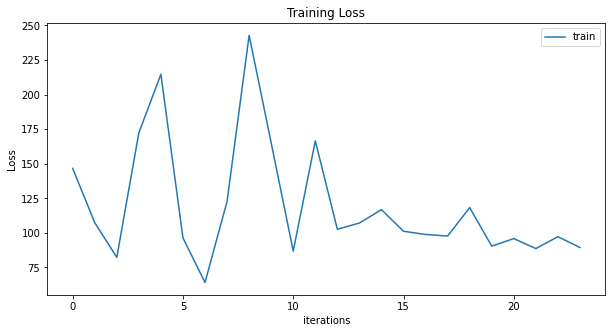

In [ ]:
import matplotlib.pyplot as plt

# plot charts
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(scores,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:

import numpy as np
trains_concat_np = train_tab[0].cpu().detach().numpy()
scores = np.zeros(16)
for i, element  in enumerate(train_tab):
    scores[i] = element.cpu().detach().numpy()

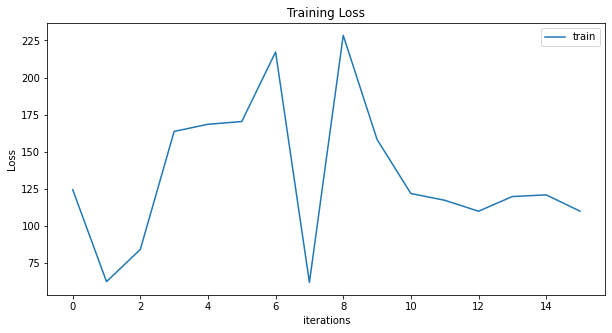

In [ ]:
import matplotlib.pyplot as plt

# plot charts
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(scores,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [19]:
torch.save(siamesenet, 'best-model2.pt')
torch.save(siamesenet.state_dict(), 'best-model-parameters2.pt')

In [20]:
!cp /content/best-model-parameters2.pt /content/drive/MyDrive/projects/Music_system_Recommender/SiameseNet
!cp /content/best-model2.pt /content/drive/MyDrive/projects/Music_system_Recommender/SiameseNet

In [ ]:
!cp '/content/drive/MyDrive/projects/Music_system_Recommender/SiameseNet/best-model-parameters.pt' '.'

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
siamesenet = SiameseNetwork(embed_model).to(device)
siamesenet.load_state_dict(torch.load('/content/best-model-parameters.pt', map_location=device))

<All keys matched successfully>

In [ ]:
import matplotlib.pyplot as plt

# PLOT embeddings from siamesenet

In [11]:
# dataset

class PlotEmbeddingsDataset(Dataset):
  def __init__(self, df, data_path):
    self.df = df #
    self.data_path = str(data_path) # /content/dataset/
    self.df['filename'] = self.df['filename'].str.replace('mp3','pt')
    self.df['filename'] = self.df['filename'].str.replace('wav','pt')

  def __len__(self):
    return len(self.df)    
    
  def __getitem__(self, idx):
    audio_file = self.data_path + self.df.loc[idx, 'filename'] # tu bylo relative_path zamiast filename
    class_id = self.df.loc[idx, 'label']
    class_id = int(class_id)
    sgram = torch.load(audio_file)
    return sgram, class_id


BATCH_SIZE = 1
df = pd.read_csv("/content/CNN_CLASIFIER_annotations_withgtzan_v2.csv")
data_path = "/content/dataset_preprocessed/"
myds = PlotEmbeddingsDataset(df, data_path)
plot_dl = torch.utils.data.DataLoader(myds, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)


In [15]:
# funkcje uporzadkowac
from sklearn.decomposition import PCA
import numpy as np
embeddings_train, labels_train = extract_embeddings(plot_dl, siamesenet)
pca = PCA(n_components=2)
principalComponents_train = pca.fit_transform(embeddings_train)


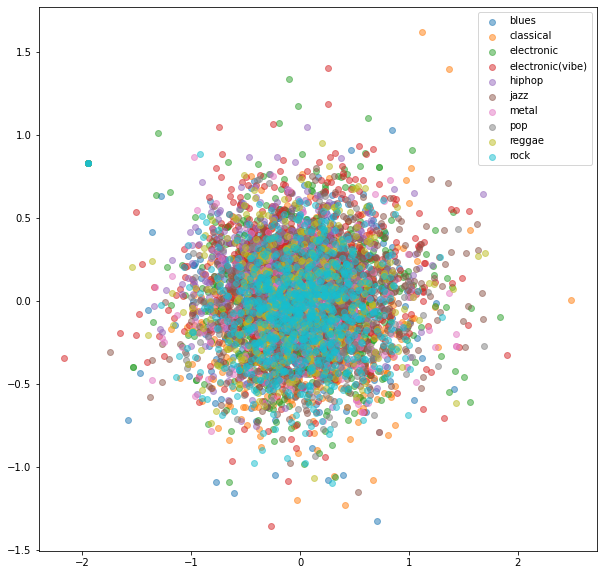

In [ ]:
audio_classes = ['blues', 'classical', 'electronic', 'electronic(vibe)', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
mnist_classes = {
    "blues" : 0,
    "classical" : 1,
    "electronic" : 2,
    "electronic(vibe)" : 3,
    "hiphop" : 4,
    "jazz" : 5,
    "metal" : 6,
    "pop" : 7,
    "reggae" : 8,
    "rock" : 9
}
plot_embeddings(principalComponents_train, labels_train)

In [17]:
import matplotlib.pyplot as plt


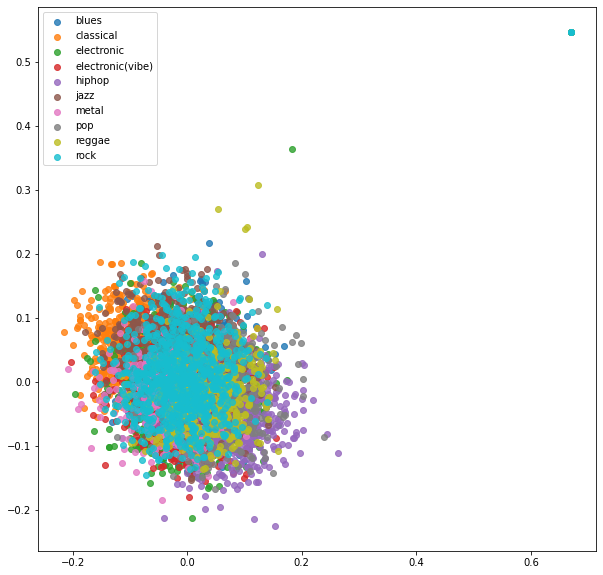

In [18]:
audio_classes = ['blues', 'classical', 'electronic', 'electronic(vibe)', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
mnist_classes = {
    "blues" : 0,
    "classical" : 1,
    "electronic" : 2,
    "electronic(vibe)" : 3,
    "hiphop" : 4,
    "jazz" : 5,
    "metal" : 6,
    "pop" : 7,
    "reggae" : 8,
    "rock" : 9
}
plot_embeddings(principalComponents_train, labels_train)

In [ ]:
# tqdm w koncu dopisac

# Triplet loss
1. Dataset return 3 samples
2. loss change in training
3. Online mining

# EDA

1. confusion matrix sie nauczyc

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

genre_dict ={
0 : 'blues',
1 : 'classic',
2 : 'electronic',
3 : 'electronic(vibe)',
4 : 'hiphop',
5 : 'jazz',
6 : 'metal',
7 : 'pop',
8 : 'reggae',
9 : 'rock'
    }

def plot_proportions(df_path):
    '''
    Pokazuje ile sampli z kazdego gatunku znajduje sie w bazie danych
    '''
    df = pd.read_csv(df_path)
    dups_labels = df.pivot_table(columns=['label'], aggfunc='size')
    values = (dups_labels.tolist())
    names = list(genre_dict.values())

    plt.bar(names, values, color ='maroon',
        width = 0.4)
    plt.xlabel("GATUNKI")
    plt.ylabel("ILE PLPIKOW")
    plt.title("JAK ZBALANSOWANA JEST BAZA DANCYH")
    plt.show()
plot_proportions("CNN_CLASIFIER_annotations_withgtzan_v2.csv")
